In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (17, 8)

import warnings
warnings.filterwarnings('ignore')

### Загрузака и предварительная очистка данных

In [2]:
df = pd.read_csv('М.Тех_Данные_к_ТЗ_DS.csv', sep=',', encoding='cp1251')
df.head(3)

,"Количество больничных дней,""Возраст"",""Пол"""
0,"5,39,""Ж"""
1,"4,54,""М"""
2,"4,26,""М"""


Видимо проблема в том, что сами данные сохранены таким образом, что их невозможно стандартным загрузчиком pandas. В таком случае будем работать с ними, как со строками, разделяя по запятым.

In [3]:
df[df.columns[0].split(',')] = df.iloc[:,0].str.split(',', expand=True)
df.drop(df.columns[0], axis=1, inplace=True)
df.head(3)

,Количество больничных дней,"""Возраст""","""Пол"""
0,5,39,"""Ж"""
1,4,54,"""М"""
2,4,26,"""М"""


Всё еще остались лишние кавычки в названии двух столбцов и в строках с полом. Удалим и их.

In [4]:
df.columns = df.columns.str.strip('"')
df['Пол'] = df['Пол'].str.strip('"')
df.head(3)

,Количество больничных дней,Возраст,Пол
0,5,39,Ж
1,4,54,М
2,4,26,М


Осталось посмотреть на типы данных и привести их к нужным.

In [5]:
df.dtypes

Количество больничных дней    object
Возраст                       object
Пол                           object
dtype: object

In [6]:
df[['Количество больничных дней', 'Возраст']] = df[['Количество больничных дней', 'Возраст']].astype(int)
df.dtypes

Количество больничных дней     int32
Возраст                        int32
Пол                           object
dtype: object

Так гораздо лучше. Теперь у нас получится легко получить описание числовых столбцов с помощью describe. Приступим к выполнению задания.

# Задание 1

Гипотеза: Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.

Сначала выберем необходимые нам данные и сохраним в отдельные датасеты.

In [7]:
men = df[df['Пол'] == 'М']
women = df[df['Пол'] == 'Ж']
men_over_two_days = men[men['Количество больничных дней'] > 2]
# men[men['Количество больничных дней'] > 2].describe()
men_over_two_days.describe()

,Количество больничных дней,Возраст
count,84.000000,84.000000
mean,4.333333,39.869048
std,1.475367,7.055340
min,3.000000,23.000000
25%,3.000000,35.000000
50%,4.000000,41.000000
75%,5.000000,45.000000
max,8.000000,57.000000


In [8]:
women_over_two_days = women[women['Количество больничных дней'] > 2]
# women[women['Количество больничных дней'] > 2].describe()
women_over_two_days.describe()

,Количество больничных дней,Возраст
count,67.000000,67.000000
mean,4.238806,40.029851
std,1.268375,6.457249
min,3.000000,23.000000
25%,3.000000,36.000000
50%,4.000000,40.000000
75%,5.000000,44.500000
max,8.000000,55.000000


### Графики

Построим некоторые графики, которые могут помочь лучше понять данные.

In [9]:
import plotly.express as px

plot_df = df[df['Количество больничных дней'] > 2]

fig = px.bar(plot_df, x='Пол', y='Количество больничных дней', color='Пол',
             title='Общее количество больничных дней в выборках (размер выборок)')
fig.show()

fig = px.box(plot_df, x='Пол', y='Количество больничных дней',
             title='Cравнение распределения количества больничных дней',
             points="all", color='Пол')
fig.show()

fig = px.histogram(men_over_two_days, x='Количество больничных дней',
                   opacity=0.5, color_discrete_sequence=['red'])
fig.update_layout(title='Количество больничных дней для мужчин',
                  xaxis_title='Количество больничных дней',
                  yaxis_title='Количество больных мужчин')
fig.show()

fig = px.histogram(women_over_two_days, x='Количество больничных дней',
                   opacity=0.7, color_discrete_sequence=['blue'])
fig.update_layout(title='Количество больничных дней для женщин',
                  xaxis_title='Количество больничных дней',
                  yaxis_title='Количество больных женщин')
fig.show()

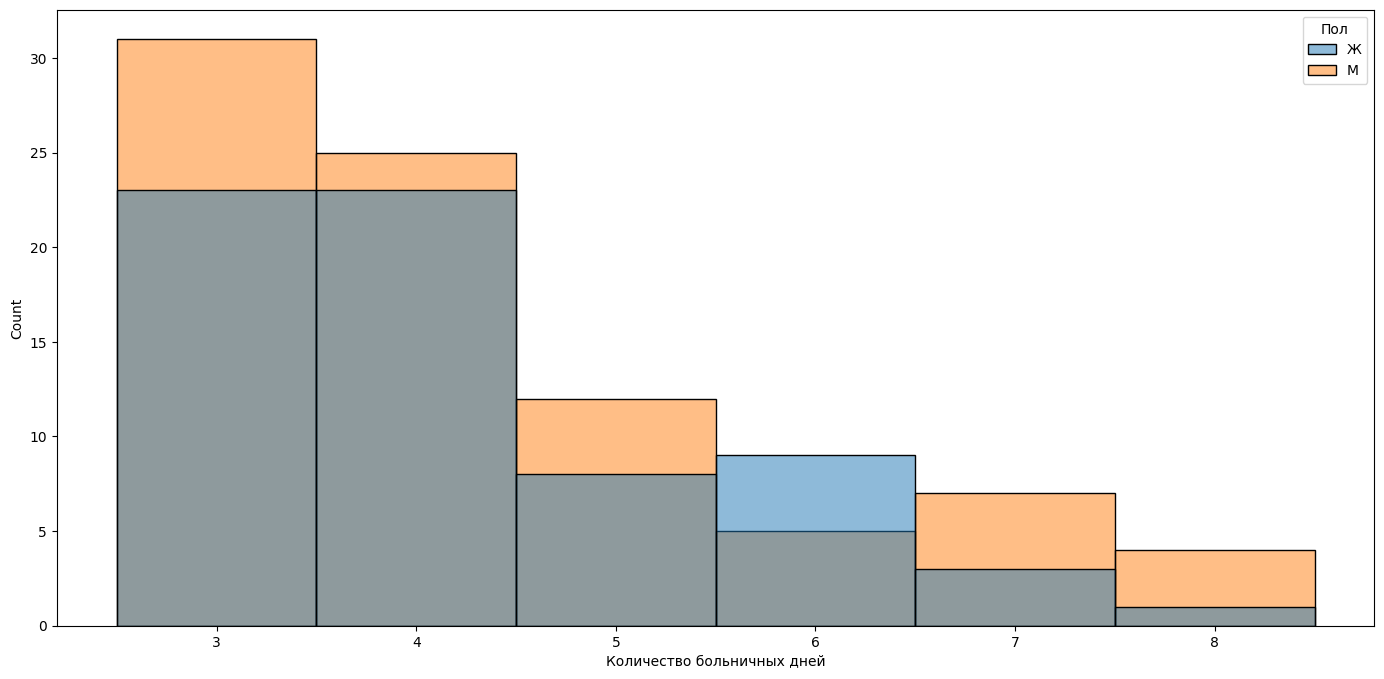

In [10]:
bin_count = np.arange(-0.5, df[df['Количество больничных дней'] > 2]['Количество больничных дней'].nunique()) + 3
pl = sns.histplot(data=df, x='Количество больничных дней', hue='Пол',
                  bins=bin_count)
# pl.set_xticks(df['Количество больничных дней'].unique());

<Axes: xlabel='Количество больничных дней', ylabel='Count'>

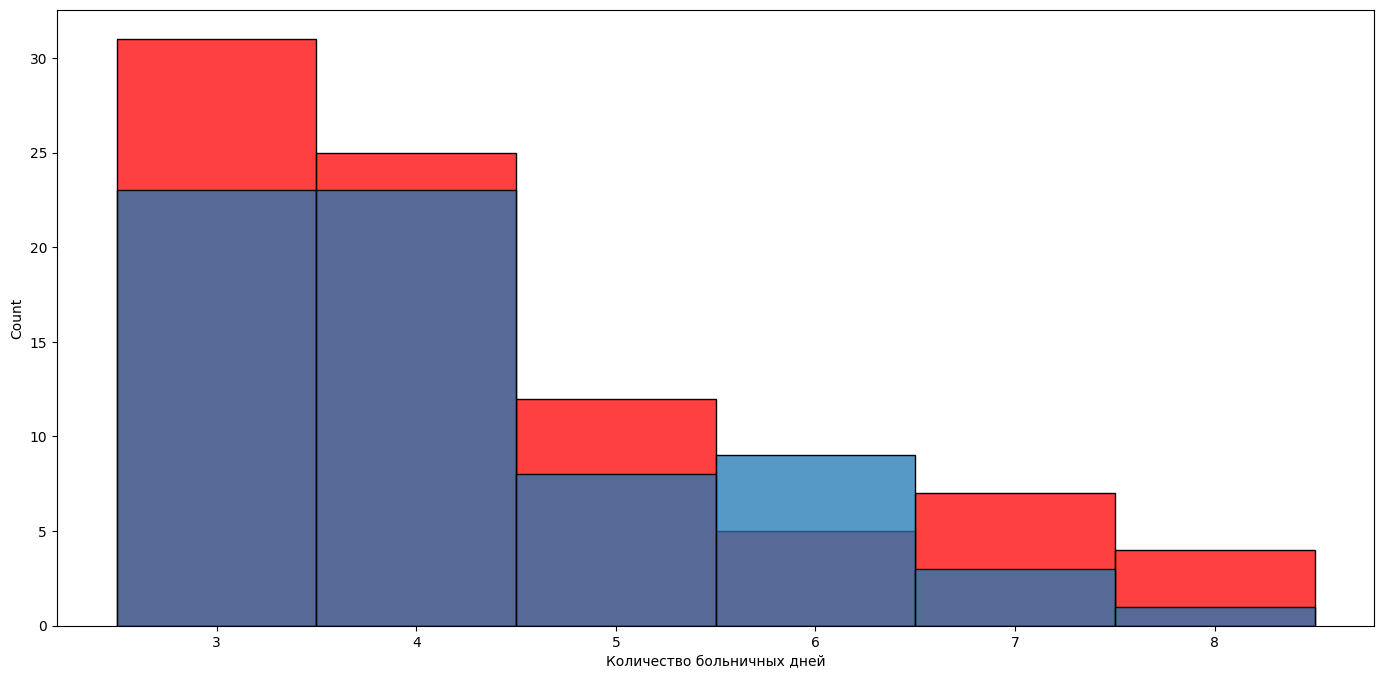

In [11]:
sns.histplot(data=men, x='Количество больничных дней', bins=bin_count, color='red')
sns.histplot(data=women, x='Количество больничных дней', bins=bin_count)

### Проверка гипотезы статистическими методами

Сформулируем гипотезы, которые хотим проверить:

Нулевая гипотеза $H_0$: между средним количеством больничных дней у мужчин и средним количеством больничных дней у женщин нет статистически значимых различий.

Альтернативная гипотеза $H_1$: среднее количество больничных дней у мужчин статистически значимо отличается от среднего количества больничных дней у женщин.

Установим уровень значимости $\alpha = 0.05 (5\%)$, т.е. хотим, чтобы доверительный интервал покрывал 95% интервала средних значений в эксперименте.

P-значением называется вероятность получить для данной вероятностной модели распределения значений случайной величины такое же или более экстремальное значение статистики (среднего арифметического, медианы и др.), по сравнению с ранее наблюдаемым, при условии, что нулевая гипотеза верна.

Проверим данные на нормальность их распределения с помощью теста  Шапиро–Уилка.

Вновь выдвигаем две гипотезы: $H_0$ - данные распределены нормально, $H_1$ - данные распределены не нормальным образом. Выберем уровень значимости $\alpha = 0.05$.

Таким образом, если $p-value > \alpha$ - то мы примем нулевую гипотезу о нормальном распределении, в противном случае принимаем альтернативную гипотезу.

In [12]:
stats.shapiro(men_over_two_days['Количество больничных дней'])

ShapiroResult(statistic=0.8159011602401733, pvalue=7.513522248814297e-09)

In [13]:
stats.shapiro(women_over_two_days['Количество больничных дней'])

ShapiroResult(statistic=0.8414593935012817, pvalue=5.730509542445361e-07)

P-value в обоих случаях оказался меньше, чем уровень значимости $\alpha$. Отвергаем нулевую гипотезу и принимаем альтернативную. Делаем следующие выводы:

Количество больничных дней как для мужчин, так и для женщин не распределены нормально.

Поскольку выборки, статистики которых мы собираемся сравнивать, распеределены ненормально, для их сравнения мы будем использовать U-test или критерий Манна-Уитни. Чем меньше значение критерия, тем вероятнее, что различия между значениями параметра в выборках достоверны.

Сформулируем гипотезы: $H_0$ - выборки взяты из одной генеральной совокупности, т.е. между ними нет статистически значимых различий, $H_1$ - выборки взяты из разных генеральных совокупностей - т.е. между ними имеются статистически значимые различия. Установим уровень значимости $\alpha = 0.05$.

In [14]:
stats.mannwhitneyu(
    men_over_two_days['Количество больничных дней'],
    women_over_two_days['Количество больничных дней']
    )

MannwhitneyuResult(statistic=2829.0, pvalue=0.9548173130538878)

$p-value > \alpha$, принимаем нулевую гипотезу и делаем вывод о том, что между выборками отсутствуют статистически значимые различия.

Проведем, также, и t-test, просто чтобы удостовериться, что даже на ненормальных данных результат будет схожим с u-критерием.

Сначала проверим отношение дисперсий выборок чтобы понять, проводить ли стандартный t-критерий Стьюдента или t-критерий Уэлча для выборок со значительно различающимеся дисперсиями

In [15]:
var1 = np.var(men_over_two_days['Количество больничных дней'])
var2 = np.var(women_over_two_days['Количество больничных дней'])
print(f'Дисперсия первой выборки = {var1:.3f}')
print(f'Дисперсия первой выборки = {var2:.3f}')
print(f'Отношение дисперсий      = {(var1 / var2):.3f}')

Дисперсия первой выборки = 2.151
Дисперсия первой выборки = 1.585
Отношение дисперсий      = 1.357


Поскольку дисперсия двух выборок находится в одних порядках (не различается в разы), указываем equal_var=True, который выполнит стандартный независимый t-test Стьюдента (в принципе по дефолту этот параметр и так True, но раз уж мы выполнили проверку дисперсий, то укажем его явным образом)

 Гипотезы для t-критерия формулируются идентично u-критерию, а уровень значимости выберем все тем же $α = 0.05$

In [16]:
stats.ttest_ind(
    men_over_two_days['Количество больничных дней'],
    women_over_two_days['Количество больничных дней']
    )

Ttest_indResult(statistic=0.41592499748510986, pvalue=0.67806332103283)

t-test также подтверждает нулевую гипотезу об отсутствии статистически значимых различий между выборками, поскольку, вновь $pvalue > α$.

# Задание 2

Гипотеза: Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.

In [17]:
old = df[df['Возраст'] > 35]
young = df[df['Возраст'] <= 35]


In [18]:
old_over_two_days = old[old['Количество больничных дней'] > 2]
young_over_two_days = young[young['Количество больничных дней'] > 2]
old_over_two_days.describe()

,Количество больничных дней,Возраст
count,115.000000,115.000000
mean,4.243478,42.756522
std,1.361058,4.804222
min,3.000000,36.000000
25%,3.000000,39.500000
50%,4.000000,42.000000
75%,5.000000,45.000000
max,8.000000,57.000000


### Графики

In [19]:
import plotly.express as px


plot_df = df[df['Количество больничных дней'] > 2]
plot_df['Возрастная категория'] = (plot_df['Возраст'] > 35).map({True: 'Старше 35', False: 'Моложе 35'})

fig = px.bar(plot_df, x='Возрастная категория',
             y='Количество больничных дней', color='Возрастная категория',
             title='Общее количество больничных дней в выборках (размер выборок)')
fig.show()

fig = px.box(plot_df, x='Возрастная категория', y='Количество больничных дней',
             title='Cравнение распределения количества больничных дней',
             points="all", color='Возрастная категория')
fig.show()

fig = px.histogram(old_over_two_days, x='Количество больничных дней',
                   opacity=0.5, color_discrete_sequence=['blue'])
fig.update_layout(title='Количество больничных дней у людей старше 35',
                  xaxis_title='Количество больничных дней',
                  yaxis_title='Количество больных людей старше 35')
fig.show()

fig = px.histogram(young_over_two_days, x='Количество больничных дней',
                   opacity=0.7, color_discrete_sequence=['red'])
fig.update_layout(title='Количество больничных дней у людей моложе 35',
                  xaxis_title='Количество больничных дней',
                  yaxis_title='Количество больных людей моложе 35')
fig.show()

In [20]:
young_over_two_days.describe()

,Количество больничных дней,Возраст
count,36.000000,36.000000
mean,4.444444,30.944444
std,1.462765,3.496483
min,3.000000,23.000000
25%,3.000000,29.000000
50%,4.000000,32.000000
75%,5.000000,34.000000
max,8.000000,35.000000


### Проверка гипотезы статистическими методами

Сформулируем гипотезы, которые хотим проверить:

Нулевая гипотеза $H_0$: между средним количеством больничных дней у людей старше 35 лет, которые болеют больше двух дней, и у людей моложе 35 лет, которые болеют больше двух дней, нет статистически значимых различий.

Альтернативная гипотеза $H_1$: среднее количество больничных дней у людей старше 35 лет, которые болеют больше двух дней статистически значимо отличается от среднего количества больничных у людей моложе 35 лет, которые болеют больше двух дней.

Установим уровень значимости $\alpha = 0.05 (5\%)$, т.е. хотим, чтобы доверительный интервал покрывал 95% интервала статистик в эксперименте.

P-значением называется вероятность получить для данной вероятностной модели распределения значений случайной величины такое же или более экстремальное значение статистики (среднего арифметического, медианы и др.), по сравнению с ранее наблюдаемым, при условии, что нулевая гипотеза верна.

Проверим данные на нормальность их распределения с помощью теста  Шапиро–Уилка.

Вновь выдвигаем две гипотезы: $H_0$ - данные распределены нормально, $H_1$ - данные распределены не нормальным образом. Выберем уровень значимости $\alpha = 0.05$.

Таким образом, если $p-value > \alpha$ - то мы примем нулевую гипотезу о нормальном распределении, в противном случае принимаем альтернативную гипотезу.

In [21]:
stats.shapiro(old_over_two_days['Количество больничных дней'])

ShapiroResult(statistic=0.8259267210960388, pvalue=2.490216088890662e-10)

In [22]:
stats.shapiro(young_over_two_days['Количество больничных дней'])

ShapiroResult(statistic=0.8257861733436584, pvalue=5.530375710804947e-05)

P-value в обоих случаях оказался меньше, чем уровень значимости $\alpha$. Отвергаем нулевую гипотезу и принимаем альтернативную. Делаем следующие выводы:

Количество больничных дней как людей старше 35, так и для людей моложе распределены не нормальным образом.

Поскольку выборки, статистики которых мы собираемся сравнивать, распеределены ненормально, для их сравнения мы будем использовать U-test или критерий Манна-Уитни. Чем меньше значение критерия, тем вероятнее, что различия между значениями параметра в выборках достоверны.

Сформулируем гипотезы: $H_0$ - выборки взяты из одной генеральной совокупности, т.е. между ними нет статистически значимых различий, $H_1$ - выборки взяты из разных генеральных совокупностей - т.е. между ними имеются статистически значимые различия. Установим уровень значимости $\alpha = 0.05$.

In [23]:
stats.mannwhitneyu(
    young_over_two_days['Количество больничных дней'],
    old_over_two_days['Количество больничных дней']
    )

MannwhitneyuResult(statistic=2252.0, pvalue=0.408297183958816)

$p-value > \alpha$, принимаем нулевую гипотезу и делаем вывод о том, что между выборками отсутствуют статистически значимые различия.

Проведем, также, и t-test, просто чтобы удостовериться, что даже на ненормальных данных результат будет схожим с u-критерием.

Проверим отношение дисперсии выборок:

In [24]:
var1 = np.var(old_over_two_days['Количество больничных дней'])
var2 = np.var(young_over_two_days['Количество больничных дней'])
print(f'Дисперсия первой выборки = {var1:.3f}')
print(f'Дисперсия первой выборки = {var2:.3f}')
print(f'Отношение дисперсий      = {(var1 / var2):.3f}')

Дисперсия первой выборки = 1.836
Дисперсия первой выборки = 2.080
Отношение дисперсий      = 0.883


Поскольку дисперсия двух выборок находится в одних порядках (не различается в разы), указываем equal_var=True, который выполнит стандартный независимый t-test Стьюдента (в принципе по дефолту этот параметр и так True, но раз уж мы выполнили проверку дисперсий, то укажем его явным образом)

In [25]:
stats.ttest_ind(
    young_over_two_days['Количество больничных дней'],
    old_over_two_days['Количество больничных дней'],
    equal_var=True
    )

Ttest_indResult(statistic=0.7594348478395395, pvalue=0.4487922957971878)

t-test также подтверждает нулевую гипотезу об отсутствии статистически значимых различий между выборками, поскольку, вновь $pvalue > α$.

### **Вывод: между выборками из работников старше 35 лет, и моложе 35 лет, которые пропускают в течении года более 2 рабочих дней по болезни нет статистически значимых различий. Другими словами, опираясь на результаты проверки гипотезы мы можем заявить, что работники старше 35 лет пропускают работу из-за болезни не чаще своих более молодых коллег.**